In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from sklearn.covariance import LedoitWolf, OAS
import pandas as pd
import math
from scipy.linalg import sqrtm
from scipy.linalg import toeplitz
from scipy.linalg import eigh
from scipy.io import savemat, loadmat
from sklearn.metrics import roc_auc_score


In [2]:
!wget http://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat http://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat

--2025-04-07 10:02:28--  http://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat [following]
--2025-04-07 10:02:28--  https://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34806917 (33M)
Saving to: ‘PaviaU.mat’

PaviaU.mat          100%[===================>]  33.19M  9.81MB/s    in 3.4s    

2025-04-07 10:02:32 (9.81 MB/s) - ‘PaviaU.mat’ saved [34806917/34806917]

URL transformed to HTTPS due to an HSTS policy
--2025-04-07 10:02:32--  https://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat
Reusing existing connection to www.ehu.eus:443.
HTTP request sent, awaiting response... 200 OK
Length: 11005 (11K)
S

In [3]:
#@title Pavia dataset

class_labels = {'1': 'Asphalt'	,
'2'	:'Meadows'	,
'3'	:'Gravel'	,
'4'	:'Trees'	,
'5'	:'Painted metal sheets'	,
'6'	: 'Bare Soil'	,
'7'	:'Bitumen'	,
'8'	:'Self Blocking Bricks'	,
'9'	:'Shadows'}


def generate_pavia_data(M = 80, B = 100, background_class = 4, downsampling_factor = 4):
  Xall = loadmat('PaviaU.mat')['paviaU']
  yall = loadmat('PaviaU_gt.mat')['paviaU_gt']
  Xall = Xall[:,:,::downsampling_factor]
  Xv = Xall.reshape(-1, Xall.shape[2])/100
  yv = yall.reshape(-1)
  D = Xall.shape[2]
  print('D=', D)
  Xb = Xv[yv==background_class,:]
  print(Xb.shape)
  N = Xb.shape[0]//2
  # test
  Xbwm = Xb[:N] - np.mean(Xb[:N], axis=0)
  C = Xbwm.T @ Xbwm / Xbwm.shape[0]
  C = np.tile(C[None,:,:],(B,1,1))
  # train
  Xtrain = Xb[N:]
  X = np.zeros((B, M, D))
  for i in range(B):
    X[i] =  Xtrain[np.random.randint(low=0,high=Xtrain.shape[0],size=(M,)),:]
    X[i] = X[i] - np.mean(X[i], axis = 0)
  return C, X , 'pavia'+str(background_class)


In [4]:
#@title Utils

def proj_PD(C, reg=1e-2):
    d, u = np.linalg.eigh(C)
    d = d * (d>=0) + reg
    Cp = np.einsum('bij,bj,bkj->bik', u, d, u)
    return Cp


def kl(C_true, C_pred):
    C_pred = proj_PD(C_pred)
    D = C_true.shape[1]
    C_inv = np.linalg.inv(C_pred)
    mult = np.matmul(C_true, C_inv)
    trace_term = np.trace(mult, axis1=1, axis2=2)
    log_det = np.linalg.slogdet(mult)[1]
    kl = 0.5 * (trace_term - D - log_det)
    kl = kl.mean()
    return kl

def invariant_kl(C_true, C_pred):
    C_pred = proj_PD(C_pred)
    D = C_true.shape[1]
    C_inv = np.linalg.inv(C_pred)
    mult = np.matmul(C_true, C_inv)
    trace_term = np.trace(mult, axis1=1, axis2=2)
    log_det = np.linalg.slogdet(mult)[1]
    kl = D/2 * np.log(trace_term/D) - 0.5 * log_det
    kl = kl.mean()
    return kl


def nsnr(C_true, C_pred):
    try:
      C_pred = proj_PD(C_pred)
      D = C_true.shape[1]
      C_si = np.linalg.cholesky(np.linalg.inv(C_pred))
      Q = np.einsum('bji,bjk,bkr->bir',C_si, C_true, C_si)
      eigs = np.linalg.eigh(Q)[0]
      kappa = np.amax(eigs,1)/np.amin(eigs,1)
      nsnr = -0.5*np.log(4*kappa/(kappa+1)**2)
      nsnr = nsnr.mean()
      return nsnr
    except:
      return np.NaN


def nmse(C_true, C_pred):
    d = ((C_true - C_pred) ** 2).mean((1,2))/((C_true) ** 2).mean((1,2))
    d = d.mean()
    return d

def compute_auc(C_pred, y_test, num_experiments=20000):
    B, D, _ = C_pred.shape
    C_pred = proj_PD(C_pred)
    inv_cov = np.linalg.inv(C_pred)
    amp = 0.6
    auc_scores = []
    for _ in range(num_experiments):
        target = np.random.rand(D)  # Target vector
        y = np.zeros(B)
        y[:B//2] = 1  # Set half to 1
        np.random.shuffle(y)
        ampy = amp * y  # Scaled labels
        y_test = y_test.reshape(B, D)
        y_test_with_target = y_test + ampy[:, None] * target[None, :]
        score = ((target.reshape(-1, 1, D) @ inv_cov @ y_test_with_target.reshape(B, D, 1)) ** 2 /
                 (target.reshape(-1, 1, D) @ inv_cov @ target.reshape(-1, D, 1)))
        auc = roc_auc_score(y, score.reshape(B))
        auc_scores.append(auc)

    avg_auc = np.mean(auc_scores)
    # print(avg_auc)
    return -1 * avg_auc


def metrics(est, C, X, mode):
    X, y = X[:, :-1, :], X[:, -1, :]
    B, M, D = X.shape
    Chat = est(X)

    m = {'EST': est.__name__,
         'M': M,
         'B': B,
         'D': D,
         'mode': mode,
         'NMSE': np.round(nmse(C, Chat), 2),
         'KL': np.round(kl(C, Chat), 2),
         'NSNR': np.round(nsnr(C, Chat), 2),
         'Neg-AUC': np.round(compute_auc(Chat, y), 2)
        }

    return m

def toeplitz_from_first_row(X):
    B, D = X.shape
    i = np.arange(D).reshape(-1, 1)
    j = np.arange(D).reshape(1, -1)
    idx = np.abs(j - i)
    T = X[:, idx]
    return T

def generate_data(D, M, B, mode):
    # np.random.seed(1)
    if mode == 'toeplitz':
        first_row = np.random.randn(B, D)
        # first_row[:,D//2:] = 0
        C = toeplitz_from_first_row(first_row)
        eigvals, eigvecs = np.linalg.eigh(C)
        min_eigval = np.amin(eigvals,-1)
        C = C + (0.1-min_eigval)[:,None,None] * np.eye(D)[None,:,:]
    elif mode == 'low rank':
        R = 5
        C = 10*np.random.randn(B, D, R)
        C = (C @ np.swapaxes(C,1,2)) / R + np.random.rand(B)[:,None,None]*np.eye(D)[None,:,:]
    elif mode == 'kron':
        D1 = 4
        D2 = D // D1
        C = np.zeros((B,D,D))
        for b in range(B):
          C1 = np.random.randn(D1)
          C1 = C1 @ C1.T / D1 + 1e-1*np.eye(D1)
          C2 = np.random.randn(D2)
          C2 = C2 @ C2.T / D2 + 1e-1*np.eye(D2)
          C[b] = np.kron(C1, C2)
    sC = np.linalg.cholesky(C)
    W = np.random.randn(B, D, M)
    X = sC @ W
    X = np.swapaxes(X,1,2)
    return C, X, mode

In [5]:
#@title Estimators

def scm(X, reg=1e-5):
    B, M, D = X.shape
    S = np.swapaxes(X,1,2) @ X / M
    return (1-reg)*S+reg*np.eye(D)[None,:,:]

def lw(X):
    B, M, D = X.shape
    Chat = np.zeros((B, D, D))
    for b in range(B):
        Xi = X[b,:,:]
        Chat[b] = LedoitWolf(assume_centered=True).fit(Xi).covariance_
    return Chat

def oas(X):
    B, M, D = X.shape
    Chat = np.zeros((B, D, D))
    for b in range(B):
        Xi = X[b,:,:]
        Chat[b] = OAS(assume_centered=True).fit(Xi).covariance_
    return Chat


def sigmashat(Y, k=None):
    # Pre-Conditions: Y is a valid pd.DataFrame and optional arg- k which can be
    # None, np.nan or int
    # Post-Condition: Sigmashat dataframe is returned

    # Set df dimensions
    N = Y.shape[0]  # num of columns
    p = Y.shape[1]  # num of rows

    # Default setting
    # if (k is None or math.isnan(k)):
    #     Y = Y.sub(Y.mean(axis=0), axis=1)  # demean
    #     k = 1

    k = 0

    # Vars
    n = N - k  # adjust effective sample size
    c = p / n  # concentration ratio

    # Cov df: sample covariance matrix
    sample = pd.DataFrame(np.matmul(Y.T.to_numpy(), Y.to_numpy()) / n)
    sample = (sample + sample.T) / 2  # make symmetrical

    # Spectral decomp
    lambda1, u = np.linalg.eigh(sample)  # use Cholesky factorisation
    lambda1 = lambda1.real.clip(min=0)  # reset negative values to 0
    dfu = pd.DataFrame(u, columns=lambda1)  # create df with column names lambda and values u
    dfu.sort_index(axis=1, inplace=True)  # sort df by column index
    lambda1 = dfu.columns  # recapture sorted lambda

    # COMPUTE Quadratic-Inverse Shrinkage estimator of the covariance matrix
    h = (min(c ** 2, 1 / c ** 2) ** 0.35) / p ** 0.35  # smoothing parameter
    invlambda = 1 / lambda1[max(1, p - n + 1) - 1:p]  # inverse of (non-null) eigenvalues
    dfl = pd.DataFrame()
    dfl['lambda'] = invlambda
    Lj = dfl[np.repeat(dfl.columns.values, min(p, n))]
    Lj = pd.DataFrame(Lj.to_numpy())  # reset column names
    Lj_i = Lj.subtract(Lj.T)  # like (1/lambda_j)-(1/lambda_i)

    theta = Lj.multiply(Lj_i).div(Lj_i.multiply(Lj_i).add(
        Lj.multiply(Lj) * h ** 2)).mean(axis=0)  # smoothed Stein shrinker
    Htheta = Lj.multiply(Lj * h).div(Lj_i.multiply(Lj_i).add(
        Lj.multiply(Lj) * h ** 2)).mean(axis=0)  # its conjugate
    Atheta2 = theta ** 2 + Htheta ** 2

    if p <= n:
        delta = 1 / ((1 - c) ** 2 * invlambda + 2 * c * (1 - c) * invlambda * theta \
                     + c ** 2 * invlambda * Atheta2)  # optimally shrunk eigenvalues
        delta = delta.to_numpy()
    else:
        delta0 = 1 / ((c - 1) * np.mean(invlambda.to_numpy()))  # shrinkage of null eigenvalues
        delta = np.repeat(delta0, p - n)
        delta = np.concatenate((delta, 1 / (invlambda * Atheta2)), axis=None)

    deltaQIS = delta * (sum(lambda1) / sum(delta))  # preserve trace

    temp1 = dfu.to_numpy()
    temp2 = np.diag(deltaQIS)
    temp3 = dfu.T.to_numpy().conjugate()

    # Reconstruct covariance matrix
    sigmashat = pd.DataFrame(np.matmul(np.matmul(temp1, temp2), temp3))
    return sigmashat.to_numpy()


def qis(X):
    B, M, D = X.shape
    Chat = np.zeros((B, D, D))
    for b in range(B):
        Xi = X[b,:,:]
        Chat[b] = sigmashat(pd.DataFrame(Xi), k=0)
    return Chat


def loocv_loglike(X, alpha):
    D, N = X.shape
    S = X @ X.T / N
    T = np.trace(S)/D * np.eye(D)
    C = (1 - alpha)*S + alpha * T
    invC = np.linalg.inv(C)
    z = np.einsum('ji,jk,ki->i', X, invC, X)  # Vector of z_i = x_i^T A_inv x_i
    trace_term = np.mean(z / (1 - (1-alpha) / N * z))
    log_det = np.log(np.linalg.det(C))
    dist = trace_term + log_det
    return dist


def loocv(X):
  alphas = np.logspace(-3,-.01,20)
  B, M, D = X.shape
  Chat = np.zeros((B, D, D))
  for b in range(B):
    Xi = X[b,:,:].T
    distances = np.array([loocv_loglike(Xi, alpha) for alpha in alphas])
    optimal_alpha = alphas[np.argmin(distances)]
    S = Xi @ Xi.T / M
    Chat[b] = (1-optimal_alpha)*S+optimal_alpha*np.trace(S)/D*np.eye(D)
  return Chat


## Experiment 1 - Synthetic Toeplitz

In [12]:
mode = 'toeplitz'
results = []
for Mi in np.linspace(20,100,9,dtype=np.int32):
  print(f'M={Mi}...')
  C, X, mode = generate_data(D = 10, M = Mi+1, B = 1000, mode='toeplitz')
  for est in [lw, qis, loocv]:
    results.append(metrics(est, C[:,:,:], X[:,:,:], mode))
df = pd.DataFrame(results)
print (df)


M=20...
M=30...
M=40...
M=50...
M=60...
M=70...
M=80...
M=90...
M=100...
      EST    M     B   D      mode  NMSE    KL  NSNR  Neg-AUC
0      lw   20  1000  10  toeplitz  0.19  1.90  1.30    -0.57
1     qis   20  1000  10  toeplitz  0.18  1.20  0.54    -0.63
2   loocv   20  1000  10  toeplitz  0.22  1.82  1.21    -0.57
3      lw   30  1000  10  toeplitz  0.15  1.71  1.20    -0.57
4     qis   30  1000  10  toeplitz  0.13  0.75  0.36    -0.65
5   loocv   30  1000  10  toeplitz  0.20  1.35  0.82    -0.60
6      lw   40  1000  10  toeplitz  0.13  1.57  1.12    -0.57
7     qis   40  1000  10  toeplitz  0.11  0.56  0.27    -0.63
8   loocv   40  1000  10  toeplitz  0.19  0.93  0.43    -0.62
9      lw   50  1000  10  toeplitz  0.11  1.42  1.03    -0.59
10    qis   50  1000  10  toeplitz  0.10  0.45  0.22    -0.65
11  loocv   50  1000  10  toeplitz  0.16  0.70  0.32    -0.65
12     lw   60  1000  10  toeplitz  0.10  1.32  0.97    -0.58
13    qis   60  1000  10  toeplitz  0.08  0.39  0.19    -0.

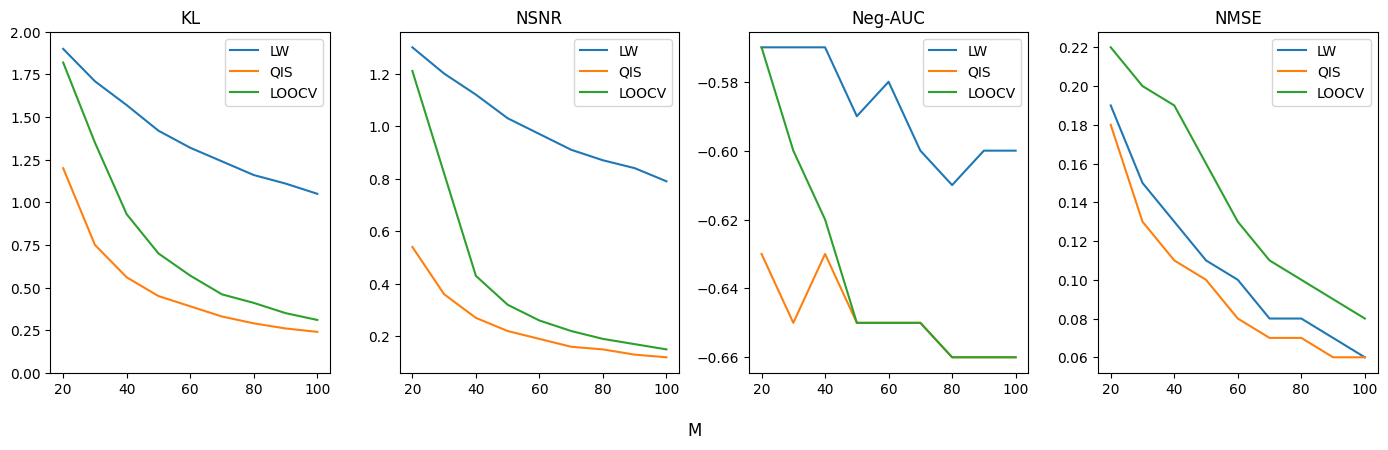

In [13]:
fig, axes = plt.subplots(1, 4, figsize=(14, 4.5))
fig.supxlabel('M')

metrics_lst = titles = ['KL', 'NSNR', 'Neg-AUC', 'NMSE']

Mlist = df.loc[df['EST'] == 'loocv', 'M'].to_numpy()
estimators = ['lw', 'qis', 'loocv']

for i, metric in enumerate(metrics_lst):
    Elist = np.array([df.loc[df['EST'] == est, metric].to_numpy() for est in estimators])
    axes[i].plot(Mlist, Elist.T)
    axes[i].legend(['LW', 'QIS', 'LOOCV'])
    axes[i].set_title(titles[i])

axes[0].axis([16, 104, 0, 2])
# axes[1].axis([16, 104, 0, 2])
# axes[2].axis([16, 104, 0, 2])

plt.tight_layout()
plt.show()


## Experiment 2 - Real Data

In [8]:
save_mat = False
for nump in [4]:
  print(f'pavia num_class = {nump}')
  mode = f'pavia{nump}'
  results = []
  for Mi in np.linspace(20,100,9,dtype=np.int32)[:]:
    C, X, mode = generate_pavia_data(M = Mi+1, B = 300, background_class=nump, downsampling_factor = 3)
    for est in [lw, qis, loocv]:
      results.append(metrics(est, C, X, mode))
  df = pd.DataFrame(results)
  print (df)

pavia num_class = 4
D= 35
(3064, 35)
D= 35
(3064, 35)
D= 35
(3064, 35)
D= 35
(3064, 35)
D= 35
(3064, 35)
D= 35
(3064, 35)
D= 35
(3064, 35)
D= 35
(3064, 35)
D= 35
(3064, 35)
      EST    M    B   D    mode  NMSE     KL  NSNR  Neg-AUC
0      lw   20  300  35  pavia4  0.30  37.56  2.87    -0.74
1     qis   20  300  35  pavia4  0.29  55.22  2.45    -0.95
2   loocv   20  300  35  pavia4  0.29  33.21  2.28    -0.93
3      lw   30  300  35  pavia4  0.25  33.55  2.69    -0.80
4     qis   30  300  35  pavia4  0.24  33.02  2.12    -0.96
5   loocv   30  300  35  pavia4  0.25  23.82  1.98    -0.95
6      lw   40  300  35  pavia4  0.23  30.49  2.56    -0.85
7     qis   40  300  35  pavia4  0.23  18.77  1.84    -0.97
8   loocv   40  300  35  pavia4  0.23  18.56  1.81    -0.97
9      lw   50  300  35  pavia4  0.22  28.43  2.46    -0.88
10    qis   50  300  35  pavia4  0.22  15.41  1.70    -0.98
11  loocv   50  300  35  pavia4  0.22  15.93  1.69    -0.98
12     lw   60  300  35  pavia4  0.21  26.26  2

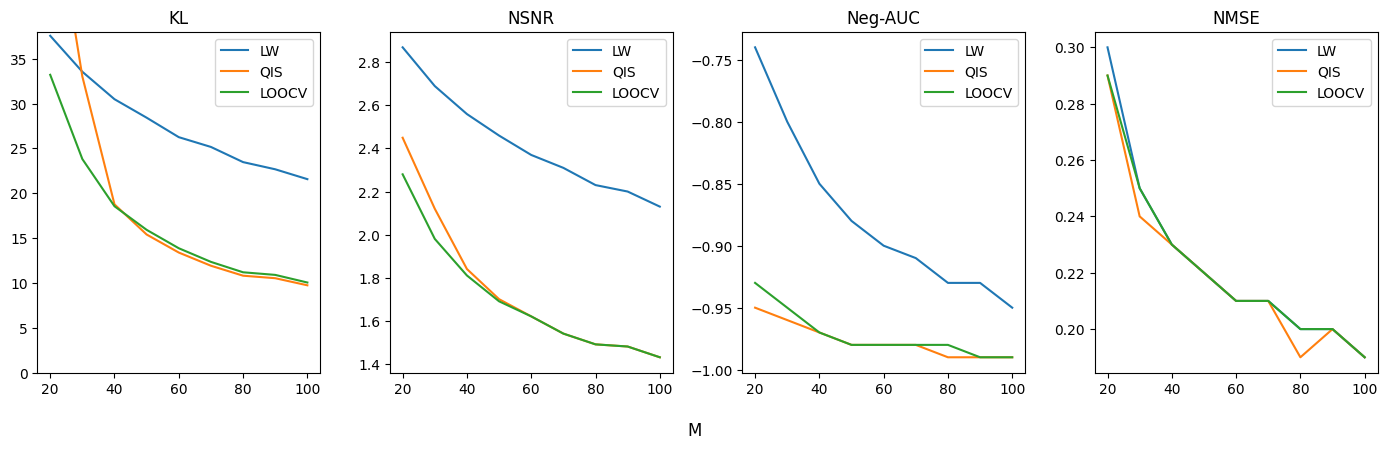

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(14, 4.5))
fig.supxlabel('M')

metrics_lst = titles = ['KL', 'NSNR', 'Neg-AUC', 'NMSE']

Mlist = df.loc[df['EST'] == 'loocv', 'M'].to_numpy()
estimators = ['lw', 'qis', 'loocv']

for i, metric in enumerate(metrics_lst):
    Elist = np.array([df.loc[df['EST'] == est, metric].to_numpy() for est in estimators])
    axes[i].plot(Mlist, Elist.T)
    axes[i].legend(['LW', 'QIS', 'LOOCV'])
    axes[i].set_title(titles[i])

axes[0].axis([16,104,0,38])
# axes[1].axis([16, 104, 0, 2])
# axes[2].axis([16, 104, 0, 2])

plt.tight_layout()
plt.show()